# 1.
Отчёт об эффективности рекламы онлайн-игры «Королевство гномов» почти готов.
Осталось добавить несколько графиков для наглядности.
Файл ch03_problems03_active_users.csv хранит данные о времени захода в игру каждым уникальным пользователем. Вот его структура:

    dt — дата посещения игры,
    user_id — уникальный идентификатор пользователя.

На основе этих данных мы уже посчитали для вас DAU — количество уникальных игроков, посетивших игру в каждый из дней.
Добавьте в датафрейм dau четыре столбца:

    скользящее среднее DAU с шириной окна 7 дней,
    скользящее среднее DAU с шириной окна 14 дней,
    скользящее медианное DAU с шириной окна 7 дней,
    скользящее медианное DAU с шириной окна 14 дней.

Подсказка
Примените к столбцу DAU из датафрейма dau цепочку методов такого вида: .rolling(ширина_окна).функция_для_агрегации().

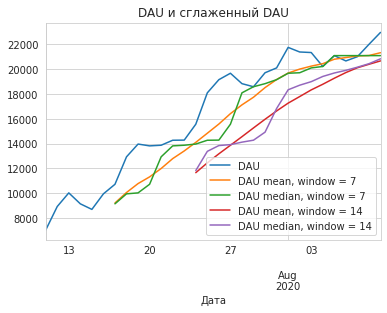

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# загружаем и преобразуем данные
dau = pd.read_csv('datasets/ch03_problems03_active_users.csv')
dau['dt'] = pd.to_datetime(dau['dt'])

# считаем количество уникальный пользователей в каждый из дней
dau = (
    dau.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'DAU'})
)

window =  7# задайте окно сглаживания
dau['DAU mean, window = 7'] =  dau['DAU'].rolling(window=window).mean()# посчитайте скользящее среднее
dau['DAU median, window = 7'] =  dau['DAU'].rolling(window=window).median()# посчитайте скользящую медиану

window =  14# задайте окно сглаживания
dau['DAU mean, window = 14'] = dau['DAU'].rolling(window=window).mean() # посчитайте скользящее среднее
dau['DAU median, window = 14'] = dau['DAU'].rolling(window=window).median() # посчитайте скользящую медиану

# строим график
dau.plot(grid = True)
plt.xlabel('Дата')
plt.title('DAU и сглаженный DAU')
plt.show()

# 2.
В коде заданы функции:

    get_profiles() — для создания пользовательских профилей,
    get_ltv() — для расчёта LTV и ROI,
    filter_data() — для сглаживания данных,
    plot_ltv_roi() — для визуализации LTV и ROI.

Применяя функцию plot_ltv_roi(), постройте графики LTV, CAC и ROI.
Установите ширину окна сглаживания в 3 дня.

Подсказка
Вызовите функцию plot_ltv_roi(), передав ей такие аргументы: ltv, ltv_history, roi, roi_history, 7 и window=3.

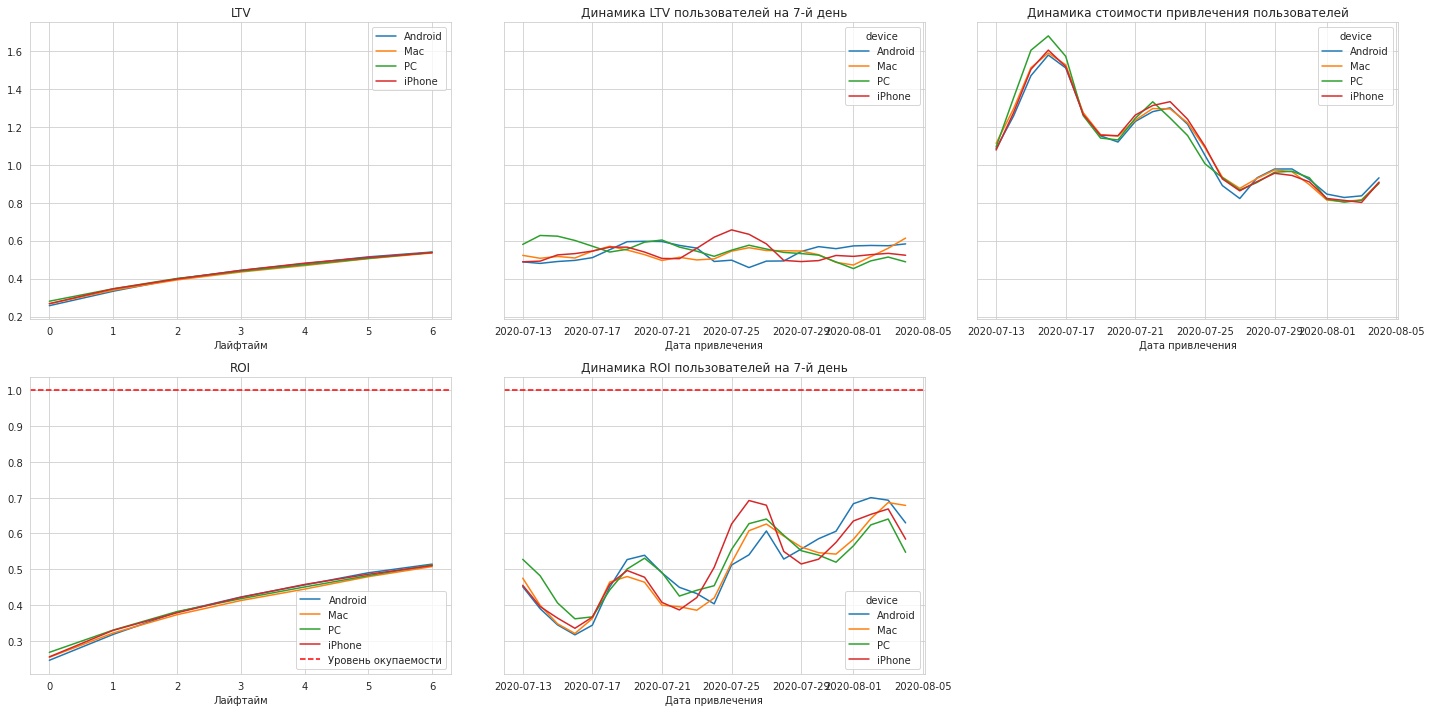

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


# функция для получения пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
            .groupby('user_id')
            .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
            .rename(columns={'session_start': 'first_ts'})
            .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


# функция для расчёта LTV и ROI
def get_ltv(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
                .agg({'acquisition_cost': 'mean'})
                .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df


# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


visits = pd.read_csv('datasets/ch02_problems03_visits.csv')  # журнал сессий
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки
ad_costs = pd.read_csv('datasets/ch02_problems02_costs.csv')  # траты на рекламу
events = None  # других событий нет

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

# разбиваем траты на рекламу по дням
min_date = datetime(2020, 7, 11)
max_date = datetime(2020, 8, 10)
days_num = (max_date - min_date).days
daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

# получаем профили с CAC
users = get_profiles(visits, purchases, events, daily_costs)

# считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, purchases, datetime(2020, 8, 10).date(), 7, dimensions=['device']
)

# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv=ltv,
             ltv_history=ltv_history,
             roi=roi,
             roi_history=roi_history,
             horizon=7,
             window=3)